# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

PCA finds correlation between features. Since the features in our dataset are categories of products, PCA would show demands relationship between products. For example, if there were a linear relationship between milk and grocery products, then a high demand for milk products would indicate a high demand for grocery products as well. PCA would show general consumer demands pattern.

ICA finds the underlying independent factors that drive the observed features. Given categories of products with amount of spending on each product category, ICA could show different types of customer segments. The idea is we can tell what a customer does base on the products he frequently purchases. For example, if a customer purchases a lot of milk products, it is likely that the customer is a pastry shop. Each customer does not generally affects the purchasing behavior of other customers; therefore we can assume that they are statistically independent. ICA would find these different types of consumer groups from our given observed spending pattern on each product category.

### PCA

In [136]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=data.shape[1])
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

The explained variance ratio plummeted on the 3rd principal component.

I’ll use 2 dimensions for my analysis. The first 2 components have significantly higher variance compared to the other lower 3 components. The lower 3 components indicate too much information loss and will likely only do more harm than good if included in our analysis.

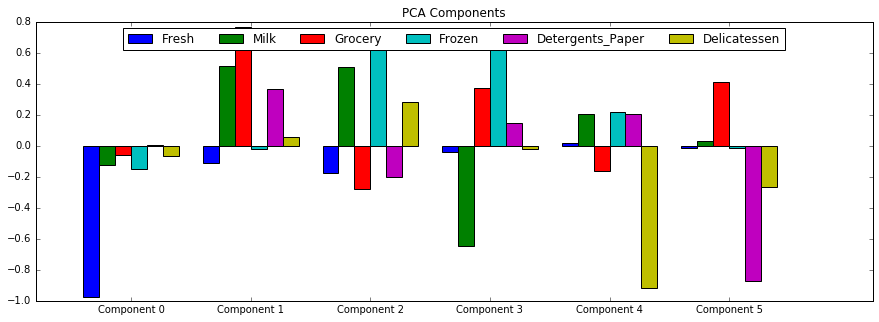

In [143]:
def visualize_comp(comp, features=None, title=None):
    curr_color = [-1]
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    
    def next_color():
        curr_color[0] = (curr_color[0] + 1) % len(colors)
        return colors[curr_color[0]]
    
    C, F = comp.shape
    ind = np.arange(C)  # the x locations for the groups
    w = 0.8             # the width of the bars
    w_b, m_2 = w / F, w / 2.


    fig, ax = plt.subplots(figsize=(15, 5))

    labels = features or ["Feature {}".format(i) for i in range(F)]
    for i, (f, l) in enumerate(zip(comp.T, labels)):
        ax.bar(ind + (w_b * i) + m_2, f, w_b, color=next_color(), label=l)

    # add some text for labels, title and axes ticks
    ax.set_title(title or "Components")
    ax.set_xticks(ind + (m_2 + (w / 2.)))
    ax.set_xticklabels(['Component {}'.format(i) for i in range(C)])
    ax.legend(loc="upper center", ncol=6)
    plt.show()

visualize_comp(pca.components_, features=list(data.columns), title="PCA Components")

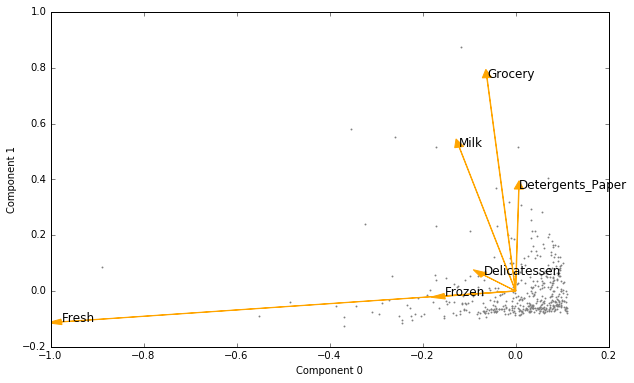

In [144]:
from sklearn.preprocessing import MinMaxScaler

def biplot(t_data, components, labels):
    scaler = MinMaxScaler().fit(t_data)
    means = scaler.transform(t_data.mean(axis=0).reshape(1, -1))
    t_data = scaler.transform(t_data) -  means

    plt.figure(figsize=(10, 6))
    plt.scatter(t_data[:, 0], t_data[:, 1], s=0.8, color='gray')
    
    for label, (xc, yc) in zip(labels, np.c_[components[0], components[1]]):
        plt.arrow(0, 0, xc, yc, width=0.001, fc='orange', ec='orange')
        plt.annotate(label, (xc, yc), size=12, color='k')
    
    plt.xlabel('Component 0')
    plt.ylabel('Component 1')
    plt.show()

# Plot first 2 components
biplot(pca.transform(data)[:, :2], components=pca.components_[:2], labels=data.columns)

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

Each component seems to represent broader categories of products. Component 1 shows milk, grocery, and detergents and paper products go along together and have strong relationship. Component 0 shows fresh products are an entirely different category by itself.

This can be useful in making decisions in inventory of stocks. For example, by looking at stocks of grocery products, the stocks for milk and detergents products can be estimated.

By grouping together categories with strong relationship, the dimensionality of the dataset is reduced while minimizing the information loss on the annual spending on the categories.

### ICA

In [145]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA()
centered_data = data - data.mean()
ica.fit(centered_data)

# Print the independent components
print ica.components_

[[ -2.09799918e-07   1.87899607e-06  -6.47209983e-06  -4.05319173e-07
    9.12275085e-07   1.47577167e-06]
 [ -3.97605274e-06   8.60451740e-07   6.31898569e-07   6.76757026e-07
   -2.07753249e-06   1.03926636e-06]
 [ -8.65158022e-07  -1.40685623e-07   7.73859147e-07   1.11462160e-05
   -5.53836527e-07  -5.95115426e-06]
 [  3.86467351e-07   2.19557632e-07   5.99918639e-07   5.22627622e-07
   -5.09424771e-07  -1.80925615e-05]
 [ -1.53904841e-07  -9.84398589e-06   5.81394497e-06   3.63136525e-07
   -3.32753166e-06   6.05545300e-06]
 [  2.98401430e-07  -2.31796540e-06  -1.20326536e-05   1.46436978e-06
    2.82008552e-05   5.72980114e-06]]


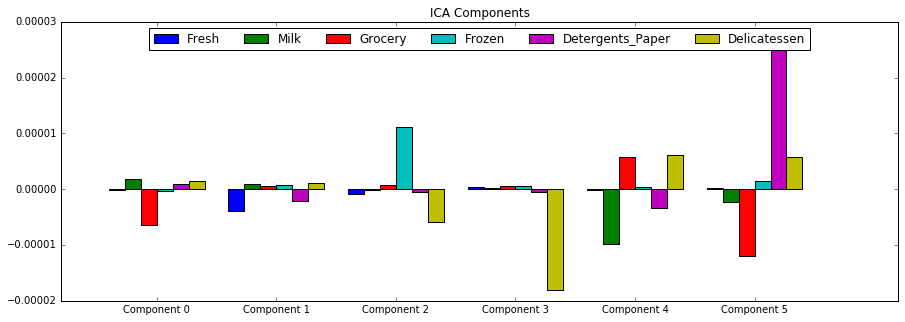

In [146]:
visualize_comp(ica.components_, features=list(data.columns), title="ICA Components")

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

**Component 0:** Corresponds to convenience/retail stores. It is dominated by grocery products, which indicates that the customer is most likely reselling those products in a smaller store.

**Component 1:** Corresponds to restaurants. It is dominated by fresh products and some detergent and paper products. Restaurants usually have suppliers for fresh produce for their menus. The need for kitchen supplies would explain their demand for detergent and paper products.

**Component 2:** Corresponds to fast food shops. It is dominated by frozen and delicatessen products. Fast food shops normally have frozen supplies for their products.

**Component 3:** Corresponds to deli counters. Delicatessen is the only dominant feature, which strongly suggests that these customers operate deli counters.

**Component 4:** Corresponds to cafés. A good portion of milk products, with grocery, deli, and detergent and paper products, this customer may be operating cafés.

**Component 5:** Corresponds to hotels. With strong demand for detergents, this customer could be operating a hotel. Hotels also have in-house food services, which would explain their demands for grocery and deli products.

These components could be use for identifying different types of customers. By identifying the type of customers, we can understand their shopping habits. Business decisions or sales/promotions can be made targeted to specific customer groups.


## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

**K-means:**
- Scales well on large number of samples
- Simple to implement and fast
- Easy to understand

**GMM:** GMM is similar to K-means, except that it applies probabilities to determine the clusters. It doesn’t hard-identify a data point, rather it shows the maximum likelihood to which cluster a data point belongs.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [147]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [149]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduce_fit = PCA(n_components=2).fit(data)
reduced_data = reduce_fit.transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [224]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
clusters = GMM(n_components=2, covariance_type='full')
clusters.fit(reduced_data)
print clusters

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [225]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [226]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.means_
print centroids

[[  3482.75173649  -3168.6558986 ]
 [-11105.12712417  10103.59888648]]


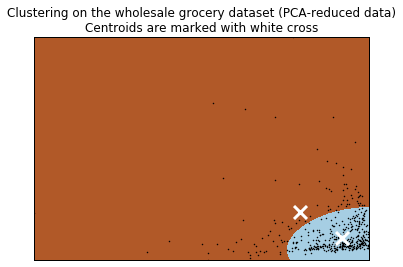

In [227]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

The customers within the cyan cluster are the low-volume customers, while those in the brown cluster are the high-volume customers.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer:

All three techniques gave useful insights into the data, depending on what we want to see. PCA showed the relationship of product demands between product categories. ICA showed different types of customers. Clustering showed low and high volume customers.

**9)** How would you use that technique to help the company design new experiments?

Answer: 

Using a combination of these techniques, we can compartmentalize customers into different groups. New experiments can be designed to target specific groups and see which groups yield positive or negative results. For example, an experiment can be conducted and see how it affects low-volume deli counter customers versus high-volume hotel customers.

**10)** How would you use that data to help you predict future customer needs?

Answer: 

With these data, we can see patterns in customer habits, and assess their needs from these. By understanding customer habits, we can design new sales and promotions targeted to specific customer groups.

If one experiment yielded a positive result among retail store customers, but not on others, then we can design a promotion with retail stores in mind.

It allows us to strategies our business decisions for different customer segments that may have different needs.